# Mesa agent based model of farm/herd pathogen strain spread

- Individual-based model for the control of Bovine Viral Diarrhea spread in livestock trade networks. Bassett et al. https://doi.org/10.1016/j.jtbi.2021.110820


In [15]:
import sys,os,random,time,string
import subprocess
import math
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
pd.set_option('max_colwidth', 200)
import pylab as plt
import seaborn as sns
import networkx as nx
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO, AlignIO
from IPython.display import display, HTML
import toyplot,toytree
import json

In [16]:
from btbabm import models
from btbabm import utils

## Parameters

* mean_stay_time - mean time in a herd
* mean_inf_time - mean infection time
* cctrans - cow-cow transmission prob
* infected_start - time step infection starts
* seq_length - sequence length
* herd_class - type of herd

In [ ]:
utils.draw_tree('tree.newick')

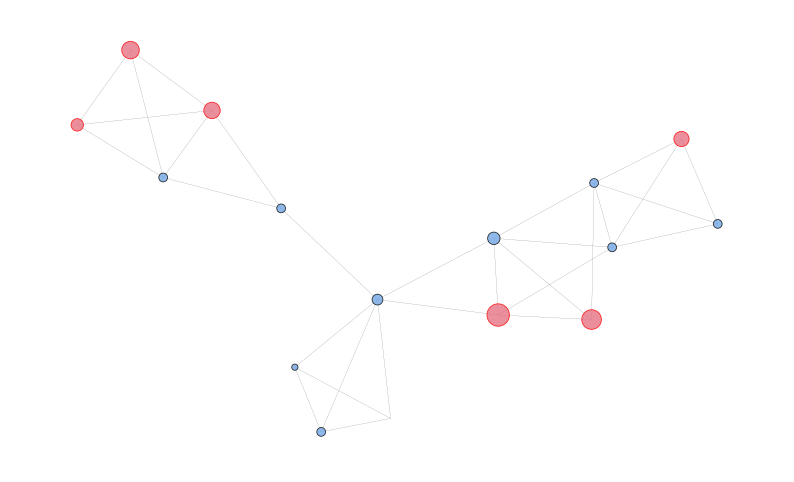

In [17]:
model = models.FarmPathogenModel(F=10,C=20,S=6)
fig,ax=plt.subplots(1,1,figsize=(10,6))
utils.plot_grid(model,ax=ax,colorby='loc_type')

## test model

In [ ]:
reload(utils)
reload(models)

model = models.FarmPathogenModel(F=30,C=800,S=10,mean_inf_time=20,mean_stay_time=150,
                       cctrans=0.01,seq_length=100,graph_type='powerlaw_cluster')
                       #, callback=print)
print (model)
fig,ax=plt.subplots(1,4,figsize=(12,4))
axs=ax.flat
st=time.time()
i=0

for s in range(1000):
    if s in [1,25,60,800]:
        utils.plot_grid(model,with_labels=True,ns='perc_infected',ax=axs[i])
        #print (model.get_farms())
        i+=1
    model.step()
#model.get_moves()
df=model.get_infected_data()
#print (df.species.value_counts())
#model.get_herds_data()
#fig=plot_herds_data(model)
#fig= utils.plot_inf_data(model)
df=model.get_column_data()
df.plot()
#print (time.time()-st)

In [ ]:
fig=utils.plot_by_species(model)

## explore parameters

In [ ]:
fig,ax=plt.subplots(3,3,figsize=(15,7))
axs=ax.flat
i=0
#for cc in np.arange(0.001,0.02,0.005):
for val in range(50,400,50):
    ax=axs[i]
    model = models.FarmPathogenModel(F=30,C=800,S=10,mean_inf_time=50,mean_stay_time=200,mean_latency_time=val,
                           cctrans=0.01,bctrans=0.01,seq_length=100,graph_type='barabasi_albert')                       
    for s in range(500):      
        model.step()
    df=model.get_infected_data()
    data = model.get_column_data()
    #print (data)
    i+=1
    data.plot(ax=ax)
    ax.set_title(val)
plt.tight_layout()


In [ ]:
cl = model.get_clades()
idf = model.get_infected_data()
x=idf.merge(cl,left_on='id',right_on='SequenceName')
x=x.set_index('SequenceName')
x.index = x.index.map(str)
col='strain'
canvas = utils.draw_tree('tree.newick',x,col,tip_labels=False,width=500)


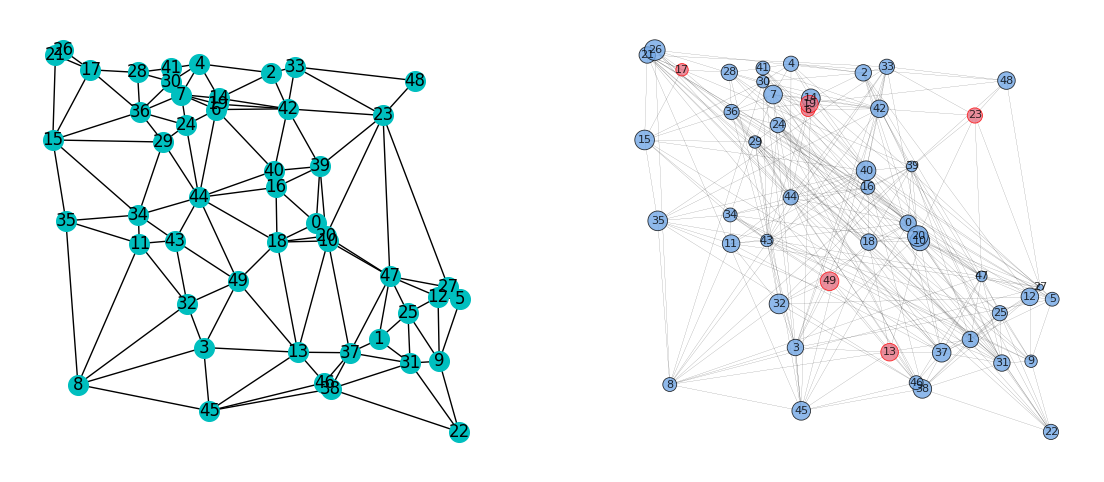

In [281]:
import geopandas as gpd
from shapely.geometry import MultiPoint,MultiPolygon,Point
reload(utils)
reload(models)
n=50
gdf = utils.random_geodataframe(n)

G,pos = utils.delaunay_pysal(gdf, 'ID', attrs=['loc_type'])
fig,ax=plt.subplots(1,2,figsize=(14,6))
nx.draw(G,pos,node_size=200,node_color='c',with_labels=True,ax=ax[0])

new_edges = utils.add_random_edges(G,4)
G.add_edges_from(new_edges)
from mesa import Agent, Model
model = models.Model()
model = models.FarmPathogenModel(F=20,C=300,S=5,graph=G)
utils.plot_grid(model,ax=ax[1],pos=pos,with_labels=True)

## dashboard

In [10]:
import panel as pn
import panel.widgets as pnw
pn.extension('tabulator', css_files=[pn.io.resources.CSS_URLS['font-awesome']])

In [266]:
reload(utils)
reload(models)

def dashboard():
    
    def run_model(farms, animals, setts, cctrans, bctrans, staytime, inftime, latencytime, infstart, steps, delay, graph_type, graph_seed, refresh):

        def callback(x):
            str_pane.value += str(x)+'\n'
            
        model = models.FarmPathogenModel(farms, animals, setts, staytime, inftime, latencytime, cctrans, bctrans, infstart, 200, 
                              None, graph_type, graph_seed=None,
                              callback=callback)
        str_pane.value = ''
        callback(model)
        fig1,ax1 = plt.subplots(1,1,figsize=(15,10))
        grid_pane.object = fig1    
        fig2,ax2 = plt.subplots(1,1,figsize=(8,6))    
        plot_pane1.object = fig2
        fig3,ax3 = plt.subplots(1,1,figsize=(8,6))   
        plot_pane2.object = fig3
        progress.max=steps
        progress.value = 0 
          
        showsteps = list(range(1,steps+1,refresh))        
        #step through the model and plot at each step
        for i in range(1,steps+1):
            model.step()            
            plt.close()
            if i in showsteps:
                ax1.clear()
                ns=nodesize_input.value
                y=model.year
                mov=len(model.get_moves())
                deaths=model.deaths
                total = len(model.get_animals())
                col = colorby_input.value
                text='day=%s year=%s moves=%s deaths=%s animals=%s' %(i,y,mov,deaths,total)
                utils.plot_grid(model,ax=ax1,
                          title=text, colorby=col, cmap=cmap_input.value,
                          ns=ns, with_labels=labels_input.value) 
                grid_pane.param.trigger('object')
                ax2.clear()        
                #s = model.circulating_strains()
                d=model.get_infected_data()
                df_pane.value = d
                hd = model.get_herds_data()
                df2_pane.value = hd
                #fig2 = utils.plot_inf_data(model)
                fig2 = utils.plot_by_species(model)
                plot_pane1.object = fig2                 
                plot_pane1.param.trigger('object')
                df = model.get_column_data()
                ax3.clear()
                df.plot(ax=ax3)
                ax3.set_xlim(0,steps)
                plot_pane2.param.trigger('object')
                html=html_tree(model)
                tree_pane.object = html
                out = model.G.nodes
                
            progress.value += 1
            time.sleep(delay)
        plt.clf()

    def html_tree(model):
        result = model.make_phylogeny()
        if result==None:
            return '<p>no tree</p>'
        cl = model.get_clades('tree.newick')    
        idf = model.get_infected_data()
        x=idf.merge(cl,left_on='id',right_on='SequenceName')
        x=x.set_index('SequenceName')
        x.index = x.index.map(str)
        tre=toytree.tree('tree.newick')
        col='strain'
        canvas = draw_tree('tree.newick',x,col,tip_labels=False,width=500)
        toyplot.html.render(canvas, "temp.html")
        with open('temp.html', 'r') as f:
            html = f.read()
        return html
      
    def set_stop(event):
        global stop
        stop = True
        print ('STOP')
  
    graph_types = ['watts_strogatz','erdos_renyi','barabasi_albert','powerlaw_cluster','random_geometric','custom']
    farm_types = ['mixed','beef','dairy','suckler']
    cmaps = ['Blues','Reds','Greens','RdBu','coolwarm','summer','winter','icefire','hot','viridis']
    grid_pane = pn.pane.Matplotlib(plt.Figure(),tight=True,width=900,height=620)
    plot_pane1 = pn.pane.Matplotlib(plt.Figure(),height=300)
    plot_pane2 = pn.pane.Matplotlib(plt.Figure(),height=300)
    tree_pane = pn.pane.HTML()
    str_pane = pnw.TextAreaInput(disabled=True,height=600,width=400) 
    df_pane = pnw.Tabulator(show_index=False,disabled=True,height=600)
    df2_pane = pnw.Tabulator(show_index=False,disabled=True,height=600)
    
    w=140
    colorby = ['num_infected','perc_infected','herd_size','loc_type','herd_class','strain']
    go_btn = pnw.Button(name='run',width=w,button_type='success')
    stop_btn = pnw.Button(name='stop',width=w,button_type='danger')
    farms_input = pnw.IntSlider(name='farms',value=20,start=5,end=1000,step=1,width=w)
    animals_input = pnw.IntSlider(name='cows',value=400,start=10,end=5000,step=10,width=w)
    setts_input = pnw.IntSlider(name='setts',value=5,start=1,end=100,step=1,width=w)
    farmtypes_input = pnw.Select(name='farm types',options=farm_types,width=w)
    cctrans_input = pnw.FloatSlider(name='CC trans',value=1,step=.1,start=0,end=5,width=w)
    bctrans_input = pnw.FloatSlider(name='BC trans',value=1,step=.1,start=0,end=5,width=w)
    staytime_input = pnw.FloatSlider(name='mean stay time',value=100,step=1,start=5,end=1000,width=w)
    inftime_input = pnw.FloatSlider(name='mean inf. time',value=60,step=1,start=5,end=600,width=w)
    latencytime_input = pnw.FloatSlider(name='mean latency time',value=100,step=1,start=10,end=600,width=w)
    infstart_input = pnw.FloatSlider(name='start infected',value=5,step=1,start=1,end=500,width=w)
    steps_input = pnw.IntSlider(name='steps',value=10,start=1,end=2000,width=w)
    refresh_input = pnw.IntSlider(name='refresh rate',value=1,start=1,end=100,width=w)
    delay_input = pnw.FloatSlider(name='step delay',value=0,start=0,end=3,step=.2,width=w)
    graph_input = pnw.Select(name='graph type',options=graph_types,width=w)
    graph_seed_input = pnw.IntInput(name='graph seed',value=10,width=w)
    #seed_input = pnw.Select(name='graph seed',options=['random'],width=w)
    colorby_input = pnw.Select(name='color by',options=colorby,width=w)
    cmap_input = pnw.Select(name='colormap',options=cmaps,width=w)
    nodesize_input = pnw.Select(name='node size',value='herd_size',options=colorby[:3],width=w)
    labels_input = pnw.Checkbox(name='node labels',value=False,width=w)
    progress = pn.indicators.Progress(name='Progress', value=0, width=600, bar_color='primary')
    
    widgets = pn.Column(pn.Tabs(('model',pn.WidgetBox(farms_input,animals_input,setts_input,farmtypes_input,cctrans_input,bctrans_input,
                                                      staytime_input,inftime_input,latencytime_input,infstart_input,steps_input,refresh_input,delay_input)), 
                                ('options',pn.WidgetBox(graph_input,graph_seed_input,colorby_input,cmap_input,nodesize_input,labels_input))), width=w+30)
    #widgets = pn.Column(go_btn)
    
    def execute(event):
        #run the model with widget 
        run_model(farms_input.value, animals_input.value, setts_input.value, cctrans_input.value/100, bctrans_input.value/100, 
                  staytime_input.value, inftime_input.value, latencytime_input.value, infstart_input.value,
                  steps_input.value, delay_input.value,graph_input.value, graph_seed_input.value, refresh_input.value)

    go_btn.param.watch(execute, 'clicks')
    
    app = pn.Column(pn.Row(go_btn,progress),
                pn.Row(widgets,grid_pane,
                 pn.Tabs(('plots',pn.Column(plot_pane1,plot_pane2)), ('tree',tree_pane), ('inf_data',df_pane), ('herd_data',df2_pane), ('debug',str_pane)),
                 sizing_mode='stretch_both',background='WhiteSmoke'))

    return app

Column
    [0] Row
        [0] Button(button_type='success', name='run', width=140)
        [1] Progress(bar_color='primary', value=0, width=600)
    [1] Row(background='WhiteSmoke', sizing_mode='stretch_both')
        [0] Column(width=170)
            [0] Tabs
                [0] WidgetBox
                    [0] IntSlider(end=1000, name='farms', start=5, value=20, width=140)
                    [1] IntSlider(end=5000, name='cows', start=10, step=10, value=400, width=140)
                    [2] IntSlider(end=100, name='setts', start=1, value=5, width=140)
                    [3] Select(name='farm types', options=['mixed', 'beef', ...], value='mixed', width=140)
                    [4] FloatSlider(end=5, name='CC trans', value=1, width=140)
                    [5] FloatSlider(end=5, name='BC trans', value=1, width=140)
                    [6] FloatSlider(end=1000, name='mean stay time', start=5, step=1, value=100, width=140)
                    [7] FloatSlider(end=600, name='mean inf. time', start=5, step=1, value=60, width=140)
                    [8] FloatSlider(end=600, name='mean latency time', start=10, step=1, value=100, width=140)
                    [9] FloatSlider(end=500, name='start infected', start=1, step=1, value=5, width=140)
                    [10] IntSlider(end=2000, name='steps', start=1, value=10, width=140)
                    [11] IntSlider(end=100, name='refresh rate', start=1, value=1, width=140)
                    [12] FloatSlider(end=3, name='step delay', step=0.2, width=140)
                [1] WidgetBox
                    [0] Select(name='graph type', options=['watts_strogatz', ...], value='watts_strogatz', width=140)
                    [1] IntInput(name='graph seed', value=10, width=140)
                    [2] Select(name='color by', options=['num_infected', ...], value='num_infected', width=140)
                    [3] Select(name='colormap', options=['Blues', 'Reds', ...], value='Blues', width=140)
                    [4] Select(name='node size', options=['num_infected', ...], value='herd_size', width=140)
                    [5] Checkbox(name='node labels', width=140)
        [1] Matplotlib(Figure, height=620, sizing_mode='fixed', tight=True, width=900)
        [2] Tabs
            [0] Column
                [0] Matplotlib(Figure, height=300, width=400)
                [1] Matplotlib(Figure, height=300, width=400)
            [1] HTML(None)
            [2] Tabulator(disabled=True, height=600, show_index=False)
            [3] Tabulator(disabled=True, height=600, show_index=False)
            [4] TextAreaInput(disabled=True, height=600, sizing_mode='fixed', width=400)
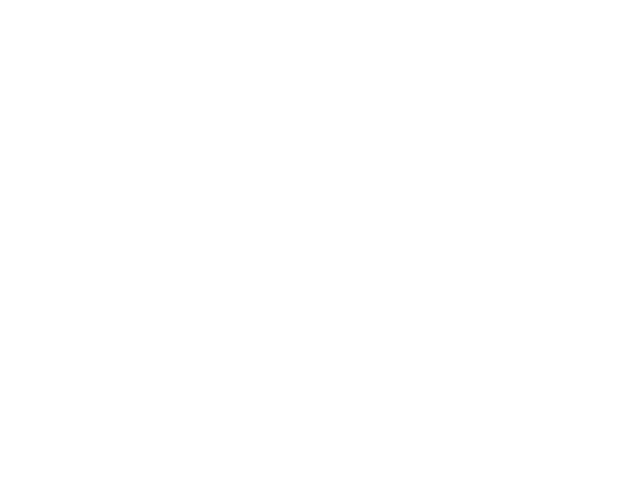
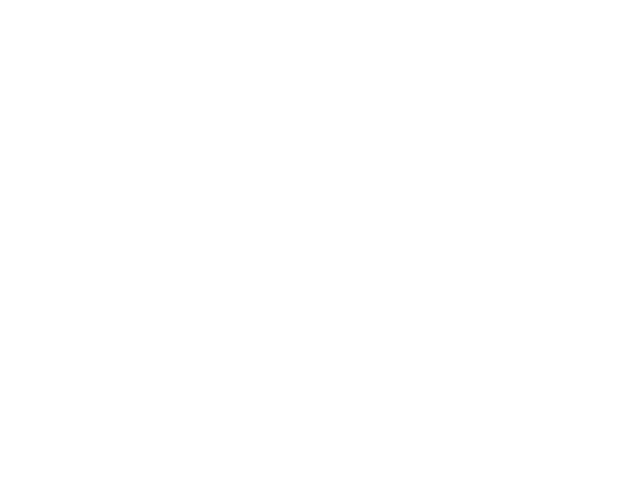
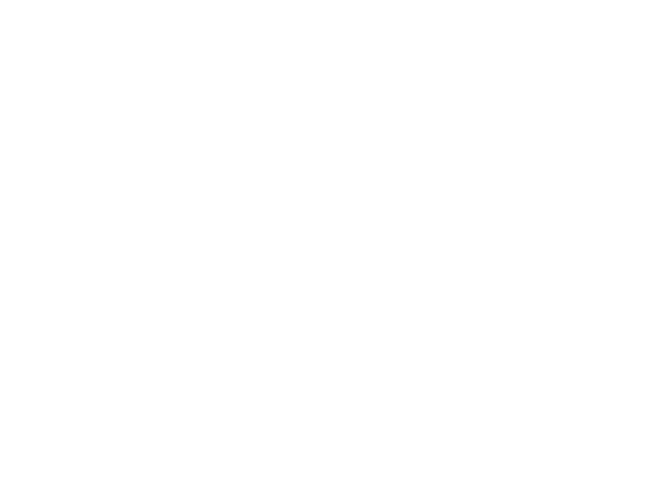

In [267]:
dashboard()

In [216]:
from bokeh.plotting import show,figure, from_networkx
from bokeh.models import (BoxZoomTool, Circle, HoverTool, Label, LabelSet,
                          MultiLine, Plot, Range1d, ResetTool)
from bokeh.models.sources import ColumnDataSource

def plot_graph_bokeh(G, data=None, node_colors=None):
   
    plot = Plot(plot_width=800, plot_height=600,
                x_range=Range1d(-1.1,1.1), y_range=Range1d(-1.1,1.1))
    plot.title.text = "Graph Plot"
    
    # Convert the networkx graph to a Bokeh graph
    graph_renderer = from_networkx(G, nx.spring_layout, scale=1, center=(0,0))
   
    # Customize the node appearance
    if node_colors is None:
        node_colors = [None] * len(G.nodes)
    graph_renderer.node_renderer.data_source.data['fill_color'] = node_colors
    graph_renderer.node_renderer.glyph = Circle(size=6, fill_color='fill_color')
    
    # Customize the edge appearance
    graph_renderer.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.8, line_width=.5)    
    # Add the graph to the plot
    plot.renderers.append(graph_renderer)    
    
    # Create a data source from the labels dictionary
    if data is None:      
        data = nx.get_node_attributes(G, 'pos')
    else:
        data = data[data.columns[:2]]
        print (data)
    #source = ColumnDataSource(data=data)
    
    # Create a label set
    #label_set = LabelSet(x='x', y='y', text='index', level='glyph',
    #              x_offset=-15, y_offset=-15, text_align='center',
    #              text_font_size="10pt", text_color="#555555", source=source, render_mode='canvas')    
    #plot.add_layout(label_set)
 
    #node_hover_tool = HoverTool(tooltips=[("id", "@id"), ("herd_class", "@herd_class"), ("infected", "@infected")])
    #plot.add_tools(node_hover_tool, BoxZoomTool(), ResetTool())
    return plot

G = utils.create_closest_n_graph(400,3)
p=plot_graph_bokeh(G, data=None, node_colors=None)
show(p)

In [ ]:
model=PathogenModel(5,10,5)
model.step()
import json
for node in model.G.nodes:
    f = model.G.nodes[node]
    json.dumps(f)

In [ ]:
def plot_grid_bokeh(model,title='',colormap='Spectral'):
    import matplotlib.cm as cm

    G = model.G
    print (graph)
    for node in G.nodes:
        G.nodes[node] = 'D'
        
    #cmap = {strains[s]: cm.get_cmap(colormap)(s/len(strains)) for s in range(len(strains))}
    #cmap[None] = f'rgb(.5,.5,.5)'
    #states = [f.main_strain() for f in model.grid.get_all_cell_contents()]
    #print (states) 
    #node_colors = [cmap[i] for i in states]   
    #node_colors = [f'rgb{(int(255*color[0]), int(255*color[1]), int(255*color[2]))}' for color in node_colors]
    #print (node_colors)
    #data = model.get_farms_data()
    p = plot_graph_bokeh(graph)#, data=data)#, node_colors=node_colors)    
    return p

p=plot_grid_bokeh(model)
print (p)
show(p)


## run model and extract relevant metrics for regression model testing